In [1]:
# Study of the effect of drive beam longitudinal rms on witness signal
import matplotlib.pyplot as plt
plt.style.use('huntstone')
import numpy as np
from scipy.constants import c
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles")
from crystal import crystal
import current_profiles as cp
from ebeam import ebeam
from laser import laser
from plotting import makefig
import phase_retard as pr
import eo_signal
import thz
sigz  = 5.2e-6
sigt  = sigz / c
def gaussian(x, A, sigma):
    arg = x / sigma
    return A * np.exp(-0.5 * arg**2)

In [2]:
# Initialize crystal and their parameters
cry = crystal('GaP');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

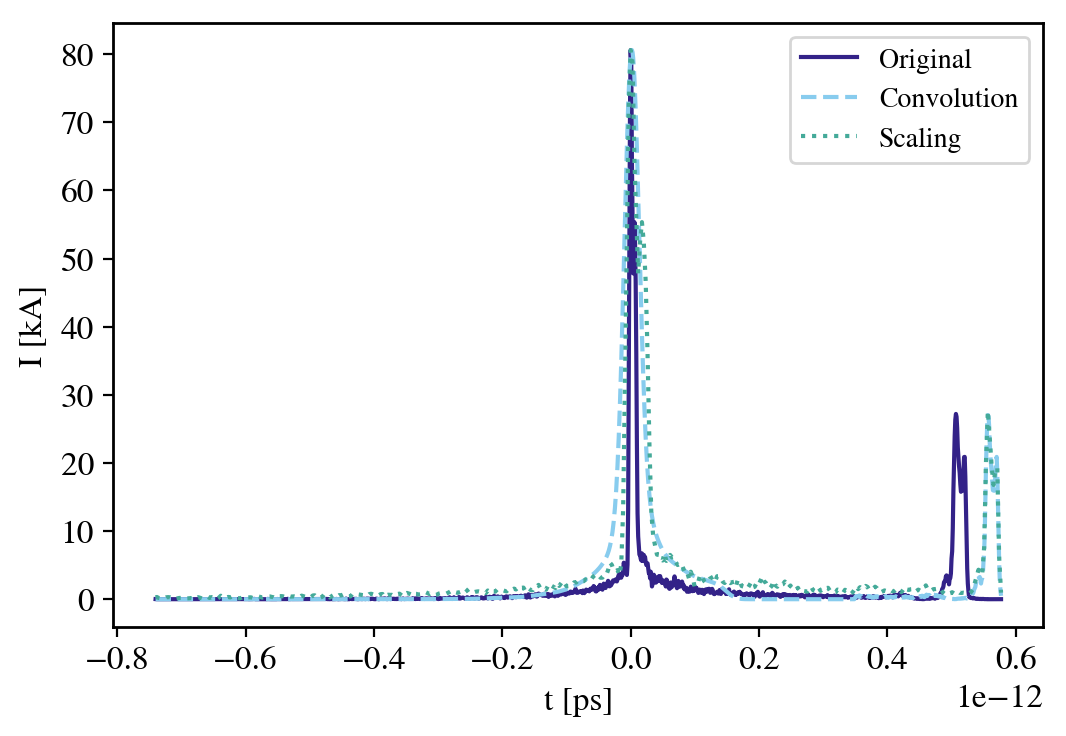

In [3]:
I, ti, zi, dz, dt = cp.get_current(6)
I_conv = cp.extend_I(I, ti, 0.3e-12, sigma = 1.8 * sigt, method = 'Gauss')
I_scale = cp.extend_I(I, ti, 0.3e-12, scaling = 3, method = 'scale')
fig, ax = makefig()
ax.plot(ti, I, label = 'Original')
ax.plot(ti, I_conv, '--', label = 'Convolution')
ax.plot(ti, I_scale, ':', label = 'Scaling' )
ax.set_xlabel('t [ps]')
ax.set_ylabel('I [kA]')
ax.legend()
plt.show()

In [4]:
def full_signal(ind, scale, method):
    I, ti, zi, dz, dt = cp.get_current(ind)
    I_conv = cp.extend_I(I, ti, 0.3e-12, sigma = sigt * scale, scaling = scale, method = method)
    # Compute electric field
    E, ze, te = cp.get_E(I_conv, ti, zi, 5e-3)
    # Make symmetric
    N      = 1000
    fE     = interp1d(te, E)
    t_use  = min([abs(te[0]), te[-1]])
    te_int = np.linspace(-t_use, t_use, N)
    E_int  = np.flip(fE(te_int))
    # Compute Signal
    FEr, f = thz.raw_field(E_int, te_int);
    Ec, tt = thz.cry_field(te_int, FEr, f, d, probe, cry, nslice = nslice, plot = False);
    tau    = np.linspace(0, 3, 1000) * 1e-12
    angle  = 15 * np.pi / 180 
    gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle, plot = False)
    sig    = np.sin(gamma / 2)**2
    sig    = sig / max(sig)
    # Center time
    t_gamma = t_gamma - t_gamma[np.argmax(sig)]
    return I_conv, ti, sig, t_gamma

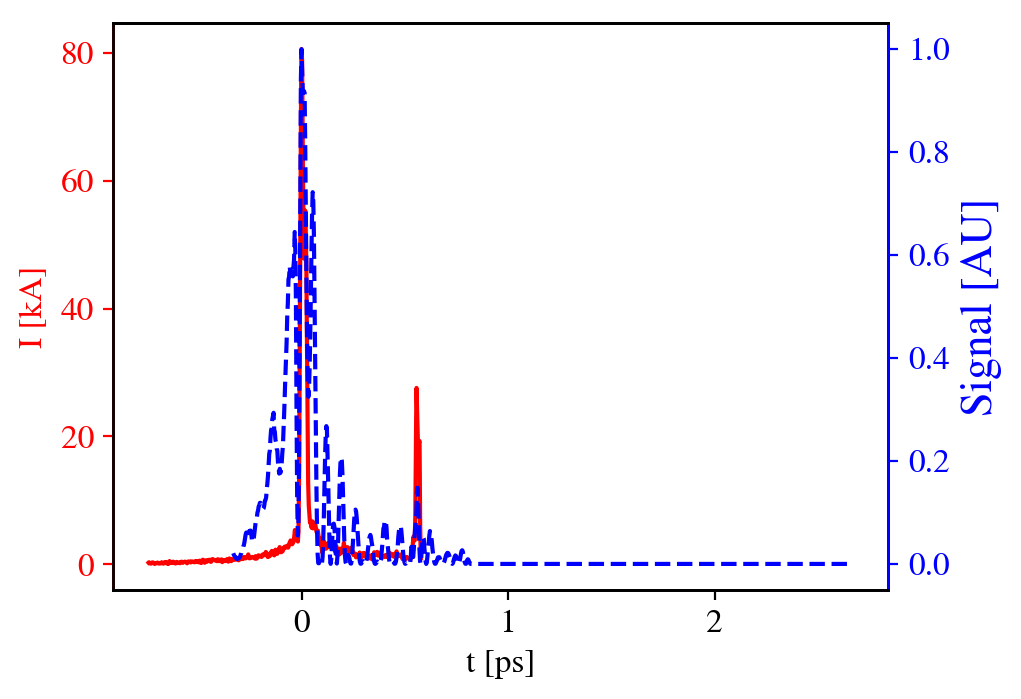

In [5]:
#I_conv, ti_conv, sig_conv, t_conv = full_signal(6, 1.5, 'Gauss')
I_scale, ti_scale, sig_scale, t_scale = full_signal(6, 3.0, 'scale')
#eo_signal.plot_signal(I_conv, sig_conv, ti_conv, t_conv)
eo_signal.plot_signal(I_scale, sig_scale, ti_scale, t_scale)

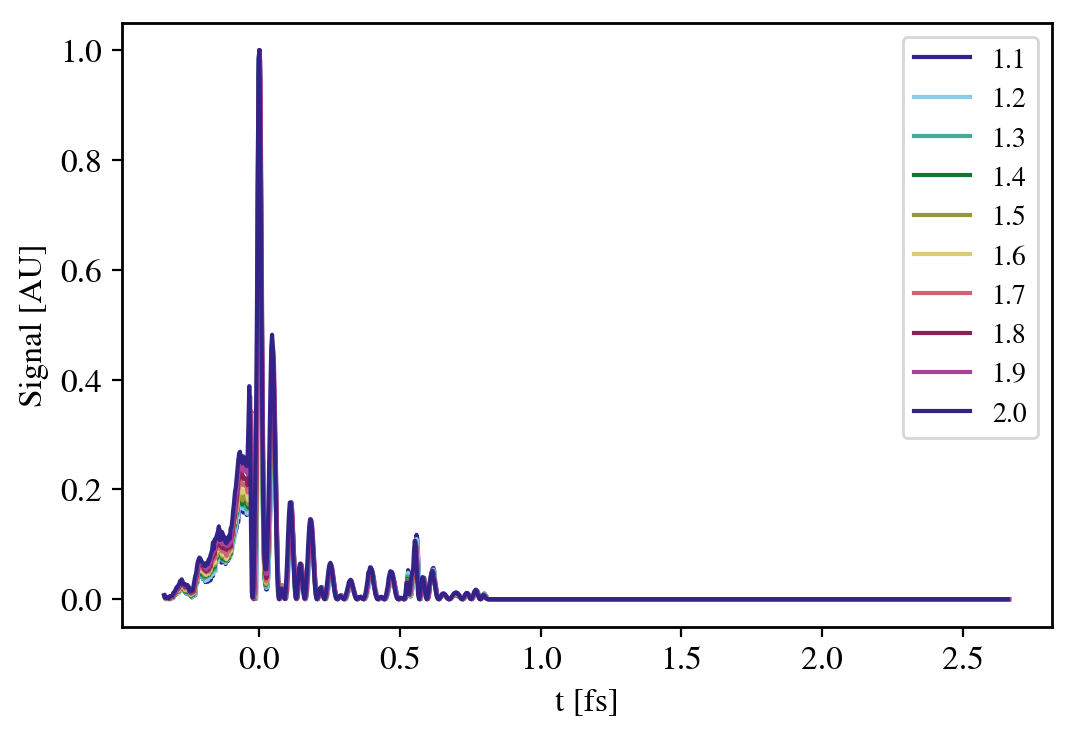

In [8]:
if True:
    scales = np.linspace(1.1, 2.0, 10)
    labels = np.round(scales, 1)#np.linspace(10, 100, 10)
    fig, ax = makefig()
    for i in range(len(scales)):
        I, ti, sig, t_gamma = full_signal(6, scales[i], 'scale')
        ax.plot(t_gamma * 1e12, sig, label = str(labels[i]))# + "%")
    ax.set_xlabel('t [fs]')
    ax.set_ylabel('Signal [AU]')
    ax.legend()
    plt.show()
#I, ti, sig, t_gamma = full_signal(6, 1.)
#eo_signal.plot_signal(I, sig, ti, t_gamma)

In [5]:
t1 = np.argmin(abs(t_gamma))
t2 = np.argmin(abs(t_gamma - 0.4e-12))
width = t2-t1
eo_signal.get_wit_stn(sig, t_gamma, 0.01e-12, 0.3e-12, 0.2, width)

0.11329651866086031

In [6]:
len(t_gamma)

1000